# Aula 01 - Parte 2
## Modelo de Câmera e Matriz de Projeção

Nesta segunda parte da aula introduziremos o modelo de câmera pinhole e conceitos básicos de geometria projetiva. Para isso vamos implementar um renderizador simples de imagens, que recebe as coordenadas de vértices em 3D e calcula a sua posição na imagem de uma câmera, em 2D.

Uma explicação interessante sobre a matriz da câmera pode ser encontrada aqui: http://ksimek.github.io/2012/08/14/decompose/

### O formato .OBJ

O formato [.OBJ](https://en.wikipedia.org/wiki/Wavefront_.obj_file) é uma maneira simples de armazenar dados de um objeto 3D de forma legível tanto para o computador quanto para seres humanos. Como o nosso objetivo não é nos aprofundarmos em computação gráfica, utilizaremos somente uma parte da informação armazenada no arquivo .OBJ, as coordenadas dos vértices em 3D.

Para carregar um arquivo .OBJ no Python instale a biblioteca *PyWavefront* com o comando:

    pip install PyWavefront


In [31]:
# Imports
import pywavefront
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Para plotar em 3D
import matplotlib.pyplot as plt
import math
import cv2

Unimplemented OBJ format statement 'g' on line 'g Object001'


<IPython.core.display.Javascript object>


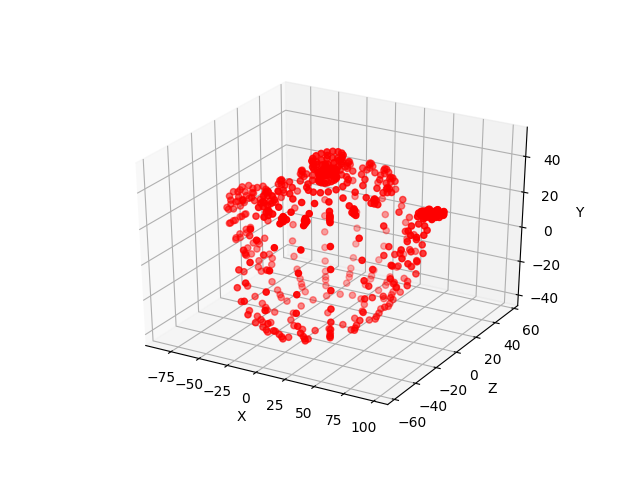

In [32]:
# Carregando as coordenadas dos vértices
scene = pywavefront.Wavefront('teapot.obj')
vertices = np.array(scene.vertices)
# Transforma para coordenadas homogêneas
vertices = np.hstack((vertices, np.ones(shape=(len(vertices), 1))))
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Visualizando...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, z, y, c='r', marker='o')  # Trocamos o y e o z só para facilitar a visualização
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

## Atividade

Sua tarefa é gerar um vídeo como o apresentado a seguir. Para isso você deve entender os seguintes conceitos:

1. Coordenadas homogêneas
2. Matrizes de transformação linear (rotação, translação e escala)
3. Modelo de câmera pinhole
4. Matriz de parâmetros intrínsecos e extrínsecos da câmera

### Dependências

Para visualizar o vídeo no jupyter notebook você vai precisar da biblioteca *cvloop*. Você pode instalá-la utilizando o *pip*:

    pip install cvloop

<IPython.core.display.Javascript object>


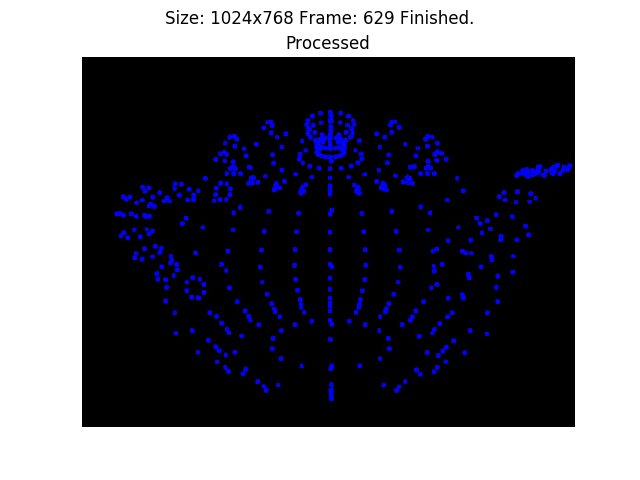

In [33]:
from cvloop import cvloop
cvloop('teapot.mp4')

### Ideia geral

A cena é gerada rotacionando a câmera ao redor do objeto. Assumindo que a câmera está fixa na origem isso é o mesmo que rotacionar o mundo (todos os objetos menos a câmera) ao redor da câmera no sentido oposto.

**Exercício**: Dados os parâmetros de câmera abaixo, montre a matriz intrínseca da câmera:

- $f_x = f_y = 500$ px
- Largura do sensor: 1024 px
- Altura do sensor: 768 px
- Ponto principal: centro do sensor

Você usará todos os parâmetros? Se não, como usará os que sobraram?

**Atenção:** não se esqueça que o ponto é representado em coordenadas homogêneas, então você sempre deve aplicar uma normalização antes de utilizar as coordenadas $x$ e $y$. Se seus pontos forem 3D, deverá adicionar uma quarta coordenada que sempre valerá 1.

In [44]:
matrix = np.array([[500, 0, 512, 0], 
                      [0, 500, 384, 0], 
                      [0, 0, 1, 0]])

**Exercício**: projete alguns pontos 3D usando sua matriz e cheque os resultados. 

In [35]:
pontos = np.array([
    (0, 0, 10, 1),
    (-1, 0, 5, 1),
    (1, 0, 2, 1),
    (0, 1, 10, 1),
    (0, -1, 3, 1)
])

gabarito = np.array([
    (512, 384, 1),
    (412, 384, 1),
    (512+250, 384, 1),
    (512, 434, 1),
    (512, 217, 1)
 
])

pontos2D = np.zeros_like(gabarito)
for i in range(0,5):
    ponto_normie = np.dot(matrix, pontos[i])
    ponto_normie = ponto_normie / ponto_normie[2]
    for j in range(0,3):
        pontos2D[i][j] = ponto_normie[j] 
print(pontos2D)
for i in range(pontos.shape[0]):
    assert(np.allclose(pontos2D[i], gabarito[i]))

[[512 384   1]
 [412 384   1]
 [762 384   1]
 [512 434   1]
 [512 217   1]]


Para plotarmos nosso objeto agora falta definirmos a matrix *extrínsica* de câmera. É ela que posiciona a câmera no mundo. Mais precisamente, é ela que posiciona o mundo na frente da câmera! Pense bem: a câmera é egocêntrica e prefere acreditar que o mundo gira e translada em torno dela. Tudo depende de seu ponto de vista. 

**Exercício**: Vamos posicionar nossa câmera no ponto $(0, 0, -100)$. 

1. Crie uma matriz de transformações **3D** *M* que translade a câmera para este ponto.
2. Compute a inversa $M^{-1}$ da matriz *M*.
3. Mostre ela no terminal. Você consegue interpretar seu efeito?

In [52]:
M = np.array([
    (1, 0, 0, 0),
    (0, 1, 0, 0),
    (0, 0, 1, -100),
    (0, 0, 0, 1)
])

M = np.linalg.inv(M)

print(M)

[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]


Com a matriz extrínseca em mãos temos nossa projeção $3D \rightarrow 2D$ completa:

1. a matriz $M^{-1}$ coloca a câmera na origem alinhada com o eixo *Z*, transformando todos os pontos 3D em outros pontos 3D.
1. a matriz *K* projeta estes pontos no plano da imagem, gerando pontos 2D.

Logo, dado um ponto 3D $p = (x, y, z, 1)$ em coordenadas homogêneas, obtemos um ponto 2D $p' = (x', y', 1)$ fazendo $KM^{-1}p$. Chamaremos esta matriz de *CaMat* (*Camera Matrix*). 

**Exercício**: Vamos agora gerar nossa primeira imagem do *teapot*. Antes de tudo, compute a matriz *CaMat*. Então, 

1. percorra a lsita de vértices e calcule sua projeção na imagem (este ponto deverá ser 2D em coordenadas homogêneas)
1. gere uma imagem com todos os pixels pretos
2. para cada ponto projetado, desenhe um círculo na imagem preta utilizando o OpenCV (função cv2.circle). 


[[ 40.6266   28.3457   -1.10804   1.     ]
 [ 40.0714   30.4443   -1.10804   1.     ]
 [ 40.7155   31.1438   -1.10804   1.     ]
 ...
 [ 22.4646   32.6095  -10.3125    1.     ]
 [ 31.1507   30.8773  -14.0083    1.     ]
 [ 34.9202   28.3457  -15.6121    1.     ]]


<IPython.core.display.Javascript object>


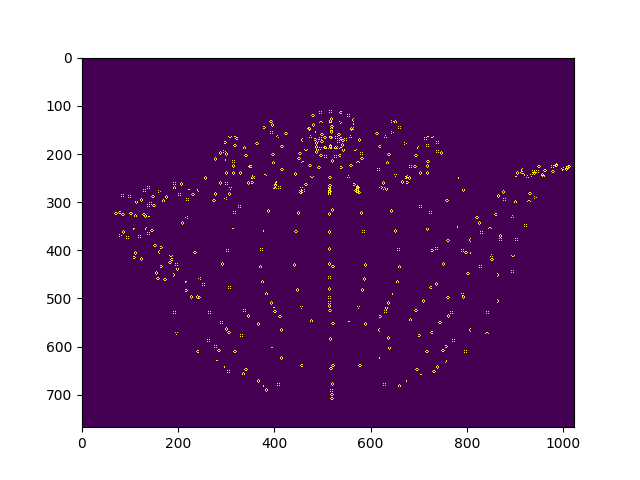

In [53]:
M_Final = np.dot(matrix, M)
print(vertices)
pontos2D_tea = np.zeros((768, 1024))
height, width = vertices.shape
for i in range(0, height):
    ponto_normie = np.dot(M_Final, vertices[i])
    ponto_normie = ponto_normie / ponto_normie[2]
    pontos2D_tea = cv2.circle(pontos2D_tea, (int(ponto_normie[0]),
                                             int(ponto_normie[1])), 3, 255)
plt.figure()
plt.imshow(pontos2D_tea, origin='upper')
    

**Exercício**: Nossa imagem aparece de ponta cabeça! Pesquise como resolver isto com um parâmetro da função `imshow`.


**Exercício**: Você consegue consertar isto mudando a matriz intrínseca? Coloque a nova matriz abaixo e rerode a célula acima. 

In [68]:
matrix = np.array([[500, 0, 512, 0], 
                      [0, -500, 384, 0], 
                      [0, 0, 1, 0]])

**Exercício**: Se posicionarmos a câmera no ponto $(0, 50, -100)$ o *teapot* se moverá para cima ou para baixo? Recrie a imagem com a câmera neste ponto e veja se sua intuição funcionou. 

In [69]:
M = np.array([
    (1, 0, 0, 0),
    (0, 1, 0, 0),
    (0, 0, 1, -100),
    (0, 0, 0, 1)
])

**Exercício**: Nossa matriz extrínseca era muito simples: ela só deslocou a câmera para trás. Vamos tentar rodá-la também agora. 

1. Volte nos slides e veja como criar uma matriz de rotação 3D ao redor do eixo vertical (Y). 
1. 

**Exercício**: vamos agora criar um vídeo da câmera rodando. Pesquise como criar vídeos usando o opencv e faça um vídeo em que a câmera rode 360 graus. Sim, o *teapot* irá "passear" e passará parte do tempo fora da imagem.

**Atenção**: o quê ocorreria se o ponto projetado estiver **atrás** da câmera. Se seu *teapot* estiver aparecendo invertido em algum momento então você precisa pensar nesta situação. 

In [70]:
def makeRotation(theta):
    RotationMatrix = np.array([[math.cos(theta), 0, -math.sin(theta), 0],
                                [0, 1, 0, 0],
                                [math.sin(theta), 0, math.cos(theta), 0],
                                [0, 0, 0, 1]])
    return RotationMatrix

In [97]:
lista_imagens = []
for i in range(0,360):
    rotate = makeRotation(np.radians(i))
    M_Final = np.dot(M, rotate)
    M_Final = np.linalg.inv(M_Final)
    M_Final = np.dot(matrix, M_Final)
    pontos2D_tea = np.zeros((768, 1024, 3), dtype=np.uint8)
    height, width = vertices.shape
    for i in range(0, height):
        ponto_normie = np.dot(M_Final, vertices[i])
        if ponto_normie[2] > 0:
            ponto_normie = ponto_normie / ponto_normie[2]
            cv2.circle(pontos2D_tea, (int(ponto_normie[0]),int(ponto_normie[1])), 3, 255)
    lista_imagens.append(pontos2D_tea)

In [98]:
size = (1024, 768)
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(lista_imagens)):
    out.write(lista_imagens[i])
out.release()


<IPython.core.display.Javascript object>


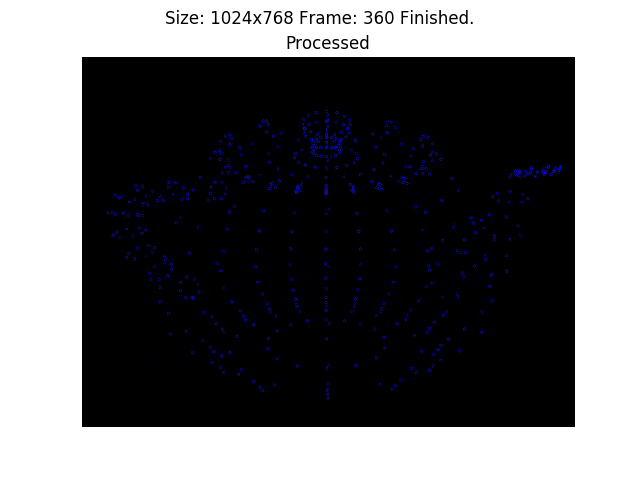

In [99]:
cvloop('project.avi')

Nosso vídeo anterior é interessante, mas não muito útil. Queremos rodar a câmera em volta do objeto, não em volta de si mesma. Ou seja, teremos que combinar dois movimentos:

1. translações que sigam a trajetória de um círculo
1. rotações que apontem para o ponto $(0, 0)$. 

**Exercício**: vamos começar com as translações. Gere agora um vídeo em que a câmera anda em volta do *teapot* (que está centrado na origem) com um raio $R=100$ e mantendo $y=0$. Você pode começar de $(0, 0, -100)$ como nas imagens anteriores. 

**Exercício**: copie seu código abaixo e adicione uma rotação para que a câmera aponte para o ponto $(0,0)$. 

## Desafios

1. Faça com que o tamanho de cada vértice dependa da sua distância até a câmera: quanto mais próximo, maior e quanto mais distante, menor.
1. Faça com que a cor de cada vértice dependa da sua distância até a câmera: quanto mais próximo, mais claro e quanto mais distante, mais escuro.
2. Implemente um movimento mais complexo para a câmera. Para isso uma possibilidade é escolher parâmetros iniciais e finais e interpolar os valores intermediários, renderizando frames para cada valor intermediário.
3. Utilize outros objetos 3D. Você pode encontrar outros exemplos de arquivos .OBJ na internet, ou exportar um modelo 3D para esse arquivo (boa parte dos programas de modelagem 3D sabe exportar para .OBJ).
4. Renderize também as faces dos objetos e não somente os vértices. Para isso você deverá ordenar as faces por distância antes de renderizar.